In [61]:
# Master File for Barrel Trigger Offline Studies on L1 Muon RoI Trigger (sans clustering)

# Description
# Meant for initially dealing with large data files for barrel

# Action Plan
# 

# Notes
# Check barrel acceptance (theoretical rationale, data supports acceptance trend)

In [62]:
work_location = input("Username? ")
if work_location == 'nasurijr':
    pwd = '/nfshome/nasurijr/delayed_jet_analyzer/'
# elif work_location == '<Insert Tier2 username here>':
#     pwd = '/home/cms/delayed_jet_analyzer/'

In [63]:
import ROOT as rt
import root_numpy as rtnp
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

import sys
sys.path.append(pwd+'lib')
from histo_utilities import create_TH1D, create_TH2D, create_TGraph, std_color_list

import os
import uproot

donotdelete = []

In [64]:
varList = [
    'nCsc',
    'cscEta',
    'cscX',
    'cscY',
    'cscZ',
    'cscPhi',
    'gLLP_decay_vertex_z',
    'gLLP_decay_vertex_y',
    'gLLP_decay_vertex_x',
    'gLLP_eta',
    'gLLP_phi',
    'jetPt'
]

In [65]:
fpath = {}
tree = {}
process = {}

data_path = pwd+'data/'
zeroBias_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/jet_timing_studies/ZeroBias-17Sep2018-v1/ZeroBias/crab_CMSSW_10_2_0_ZeroBias-Run2018B-17Sep2018-v1_jettimingstudies_CaltechT2/190711_205018/0000/'

fpath['qcd'] = data_path +'jet_timing_studies_ntuple_RunIIFall17DRPremix_QCD_Pt_170to300_TuneCP5_13TeV_pythia8_1.root'
# fpath['zeroBias'] = data_path +'jet_timing_studies_ZeroBias_Run2018A_roctest2.root'
# fpath['zeroBias'] = data_path + 'jet_timing_studies_ZeroBias_Run2018B_112_dec.root'
fpath['zeroBias'] = data_path + 'jet_timing_studies_ZeroBias_Run2018AB_complete.root'


# mH = 125 GeV, mX = 50 GeV, ctau = 1 m ['ggH']
fpath['ggH'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl1000_ev100000.root'

# mH = 125 GeV, mX = 50 GeV, ctau = 10 m
fpath['m50ct10000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl10000_ev100000.root'
# fpath['ggH'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl10000_ev100000.root'


# mH = 2000 GeV, mX = 975 GeV, ctau = 1 m
fpath['m975ct1000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl1000_ev100000.root'
# fpath['ggH'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl1000_ev100000.root'

# mH = 2000 GeV, mX = 975 GeV, ctau = 10 m
fpath['m975ct10000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl10000_ev100000.root'
# fpath['ggH'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl10000_ev100000.root'

for k,v in fpath.items():
    print(str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
    print(k, v)
#     tree[k] = rtnp.root2array(v, branches=varList)
    root_dir = uproot.open(v) 
    tree[k] = root_dir['ntuples']['llp']
#     a = tree[k]["cscZ"]
    a = tree[k]["jetPt"].array()
    print(a[:-1][0])

2019-07-22 19:40:29.363063-07:00
qcd /nfshome/nasurijr/delayed_jet_analyzer/data/jet_timing_studies_ntuple_RunIIFall17DRPremix_QCD_Pt_170to300_TuneCP5_13TeV_pythia8_1.root
[231.354     87.641464  56.886036]
2019-07-22 19:40:29.883278-07:00
zeroBias /nfshome/nasurijr/delayed_jet_analyzer/data/jet_timing_studies_ZeroBias_Run2018AB_complete.root
[]
2019-07-22 19:42:54.367354-07:00
ggH /nfshome/nasurijr/delayed_jet_analyzer/data/jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl1000_ev100000.root
[]
2019-07-22 19:42:54.949516-07:00
m50ct10000mm /nfshome/nasurijr/delayed_jet_analyzer/data/jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl10000_ev100000.root
[23.463825 22.805841]
2019-07-22 19:42:55.247539-07:00
m975ct1000mm /nfshome/nasurijr/delayed_jet_analyzer/data/jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl1000_ev100000.root
[274.2714   197.74245  178.33418   34.052208  26.607008]
2019-07-22 19:42:55.498383-07:00
m975ct10000mm /nfshome/nasurijr/delayed_jet_analyzer/data

In [66]:
T = tree['ggH']
T_bkg = tree['qcd']
T_minBias = tree['zeroBias']
T_low_ctau10 = tree['m50ct10000mm']
T_high_ctau1 = tree['m975ct1000mm']
T_high_ctau10 = tree['m975ct10000mm']

In [67]:
#get first jet pt per event
# print(T['jetPt'])
first_jet_pt = [x[0] if len(x) else -1 for x in T['jetPt'].array()]

x = np.arange(-5, 5, 1)
y = np.arange(-5, 5, 1)
xx, yy = np.meshgrid(x, y, sparse=True)

#get max jet pt per event
max_jet_pt = [np.max(np.abs(x)) if len(x) else -1 for x in T['gLLP_decay_vertex_z'].array()]

#store jet-pt array per event in a list
first_jet_pt_arr = []
for x in T['jetPt'].array():
    if len(x) == 0:
        break
    #print x
    first_jet_pt_arr.append(x[0])

In [68]:
# k-means clustering algorithm

MAX_ITERATIONS = 100
# Function: Should Stop
# -------------
# Returns True or False if k-means is done. K-means terminates either
# because it has run a maximum number of iterations OR the centroids
# stop changing.
def shouldStop(oldCentroids, centroids, iterations):
    if iterations > MAX_ITERATIONS: return True
    return np.array_equal(oldCentroids,centroids) and iterations > 0


# Function: Get Labels
# -------------
# Returns a label for each piece of data in the dataset. 
def getLabels(dataSet, centroids, i):
    #print 1
    #for i in dataSet:
    dist = cdist( dataSet, centroids, metric='euclidean' )
    
    #print dist
    if i < 1:
        dist[dist>1.0] = 999
    elif i < 2:
        dist[dist>0.8] = 999
    else:
        dist[dist>0.4] = 999
        
    #print dist
    #print np.argmin(dist, axis=1)
    return np.argmin(dist, axis=1)
    #print dataSet
    # For each element in the dataset, chose the closest centroid. 
    # Make that centroid the element's label.

# Function: Get Centroids
# -------------
# Returns k centroids, each of dimension n.
def getCentroids(dataSet, centroids, labels, k):
    #print centroids
    newcentroid = np.empty((0,2))
    new_centroid_constituents = []
    for i in range(k):
        sel = labels[:] == i
        #print i, dataSet[sel], np.count_nonzero(dataSet[sel])/2
        if np.count_nonzero(dataSet[sel]) > 0:
            #print np.average(dataSet[sel], axis=0)
            #newcentroid.append(np.average(dataSet[sel], axis=0))
            selected = [np.average(dataSet[sel], axis=0)]
            for val in selected:
                newcentroid = np.append(newcentroid,[val], axis=0)
            #newcentroid = np.append(newcentroid,np.average(dataSet[sel], axis=0), axis=0)
            new_centroid_constituents.append(np.count_nonzero(dataSet[sel])/2)
        else:
            newcentroid = np.append(newcentroid,[centroids[i]],axis=0)
            new_centroid_constituents.append(0)
    
    return newcentroid,new_centroid_constituents
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    
# Function: Get Centroids
# -------------
# Returns k random centroids, each of dimension n.
def getRandomCentroids():
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    even_list = np.linspace(-4.0, 4.0, num=5)
    centers  = np.empty((0,2))
    for i in even_list:
        for j in even_list:
            #print i,j
            new_arr = np.array([i,j])
            centers = np.append(centers,[new_arr],axis=0)
    #print centers
    return centers
    #return np.mgrid[-4:4.1:2, -4:4.1:2].reshape(2,-1).T
    #return np.random.rand(k,numFeatures)

# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
def kmeans(dataSet, k):
    # Initialize centroids randomly
    numFeatures = dataSet.ndim
    centroids = getRandomCentroids()
    centroid_constituents = np.repeat(-999, 25)
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.empty((25,2))
    oldCentroids[:] = centroids
    #np.random.rand(1,2)
    #print centroids
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids[:] = centroids
        #print oldCentroids
        #print 'iter', iterations
        
        # Assign labels to each datapoint based on centroids
        labels = getLabels(dataSet, centroids, iterations)
        # Assign centroids based on datapoint labels
        
        centroids,centroid_constituents = getCentroids(dataSet, oldCentroids, labels, k)
        #print centroids
        iterations += 1
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    return centroids,centroid_constituents

In [69]:
# Variable Definitions

# CSC
nCsc = {}
csc_z = {}
csc_x = {}
csc_y = {}
csc_eta = {}
csc_phi = {}
# Gen Level
gLLP_eta = {}
gLLP_r = {}
gLLP_decay = {}
# Drift Tube (DT)
nDt = {}
dt_phi = {}
dt_eta = {}
dt_z = {}
dt_x = {}
dt_y = {}
# RPC
nRpc = {}
rpc_phi = {}
rpc_eta = {}
rpc_z = {}
rpc_x = {}
rpc_y = {}


data_trees = {'ggH': T, 'qcd': T_bkg, 'zeroBias':T_minBias, 'm50ct10m': T_low_ctau10, 'm975ct1m': T_high_ctau1, 'm975ct10m': T_high_ctau10}

In [70]:
# Signal Selection

print('Start: ' + str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
if 'metbb' in fpath['ggH']:
    for species, arbor in data_trees.items():
        gLLP_r[species] = np.sqrt((arbor['gLLP_decay_vertex_x'].array()[:,0])**2+(arbor['gLLP_decay_vertex_y'].array()[:,0])**2)
        gLLP_decay[species] = np.sqrt((arbor['gLLP_decay_vertex_x'].array()[:,0])**2+(arbor['gLLP_decay_vertex_y'].array()[:,0])**2 + (arbor['gLLP_decay_vertex_z'].array()[:,0])**2)
        
        sel_csc = np.logical_and(np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) > 568 , np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) < 1100)
        sel_csc = np.logical_and(sel_csc, np.absolute(arbor['gLLP_eta'].array()[:,0])<2.4)
        sel_csc = np.logical_and(sel_csc, np.absolute(arbor['gLLP_eta'].array()[:,0])>0.9)
        sel_csc = np.logical_and(sel_csc, np.absolute(gLLP_r[species])<695.5)

        sel_barrel = np.logical_and(np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) > -661 , np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) < 661)
        sel_barrel = np.logical_and(sel_barrel, np.absolute(gLLP_r[species])<738)
        sel_barrel = np.logical_and(sel_barrel, np.absolute(gLLP_r[species])>380)

        sel_rpc = np.logical_and(np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) > 0 , np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) < 1100)
        sel_rpc = np.logical_and(sel_rpc, np.absolute(arbor['gLLP_eta'].array()[:,0])<1.6)
        sel_rpc = np.logical_and(sel_rpc, np.absolute(gLLP_r[species])<738)
        sel_rpc = np.logical_and(sel_rpc, np.absolute(gLLP_r[species])>275)

        sel_dis_signal = np.logical_or(sel_csc, sel_barrel)

#         sel_bkg = [True if np.any(x > 50) else False for x in T_bkg['jetPt']]
#         sel_minBias = [True if np.any(x > 50) else False for x in T_minBias['jetPt']]
        
        if species in ('ggH', 'm50ct10m', 'm975ct1m', 'm975ct10m'):
#             nCsc[species] = arbor['nCsc'].array()[sel_barrel]
#             csc_z[species] = arbor['cscZ'].array()[sel_barrel]
#             csc_x[species] = arbor['cscX'].array()[sel_barrel]
#             csc_y[species] = arbor['cscY'].array()[sel_barrel]
#             csc_eta[species] = arbor['cscEta'].array()[sel_barrel]
#             csc_phi[species] = arbor['cscPhi'].array()[sel_barrel]
            gLLP_eta[species] = arbor['gLLP_eta'].array()[:,0][sel_barrel]
            
            nDt[species] = arbor['nDt'].array()[sel_barrel]
            dt_z[species] = arbor['dtZ'].array()[sel_barrel]
            dt_x[species] = arbor['dtX'].array()[sel_barrel]
            dt_y[species] = arbor['dtY'].array()[sel_barrel]
            rpc_eta[species] = arbor['dtEta'].array()[sel_barrel]
            rpc_phi[species] = arbor['dtPhi'].array()[sel_barrel]
            
            nRpc[species] = arbor['nRpc'].array()[sel_rpc]
            rpc_z[species] = arbor['rpcZ'].array()[sel_rpc]
            rpc_x[species] = arbor['rpcX'].array()[sel_rpc]
            rpc_y[species] = arbor['rpcY'].array()[sel_rpc]
            rpc_eta[species] = arbor['rpcEta'].array()[sel_rpc]
            rpc_phi[species] = arbor['rpcPhi'].array()[sel_rpc]

        if species in ('qcd', 'zeroBias'):
            sel_bkg = [True if np.any(x > 50) else False for x in arbor['jetPt'].array()]
            
#             nCsc[species] = arbor['nCsc'].array()[sel_bkg]
#             csc_z[species] = arbor['cscZ'].array()[sel_bkg]
#             csc_x[species] = arbor['cscX'].array()[sel_bkg]
#             csc_y[species] = arbor['cscY'].array()[sel_bkg]
#             csc_eta[species] = arbor['cscEta'].array()[sel_bkg]
#             csc_phi[species] = arbor['cscPhi'].array()[sel_bkg]
            gLLP_eta[species] = arbor['gLLP_eta'].array()[:,0][sel_bkg]
            
            nDt[species] = arbor['nDt'].array()[sel_bkg]
            dt_z[species] = arbor['dtZ'].array()[sel_bkg]
            dt_x[species] = arbor['dtX'].array()[sel_bkg]
            dt_y[species] = arbor['dtY'].array()[sel_bkg]
            dt_eta[species] = arbor['dtEta'].array()[sel_bkg]
            dt_phi[species] = arbor['dtPhi'].array()[sel_bkg]
            
            nRpc[species] = arbor['nRpc'].array()[sel_bkg]
            rpc_z[species] = arbor['rpcZ'].array()[sel_bkg]
            rpc_x[species] = arbor['rpcX'].array()[sel_bkg]
            rpc_y[species] = arbor['rpcY'].array()[sel_bkg]
            rpc_eta[species] = arbor['rpcEta'].array()[sel_bkg]
            rpc_phi[species] = arbor['rpcPhi'].array()[sel_bkg]
            
#         if species == 'zeroBias':
#             nCsc[species] = arbor['nCsc'][sel_minBias]
# #             pg_ncsc_sel[species] = np.array(pg_ncsc[species])[sel_minBias]            
#             csc_z[species] = arbor['cscZ'][sel_minBias]
#             csc_x[species] = arbor['cscX'][sel_minBias]
#             csc_y[species] = arbor['cscY'][sel_minBias]
#             csc_t[species] = arbor['cscT'][sel_minBias]            
#             csc_eta[species] = arbor['cscEta'][sel_minBias]
#             csc_phi[species] = arbor['cscPhi'][sel_minBias]
        
        print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

Start: 2019-07-22 19:43:01.263949-07:00
ggH: 2019-07-22 19:43:01.563535-07:00
qcd: 2019-07-22 19:43:03.209320-07:00
zeroBias: 2019-07-22 20:33:52.237004-07:00
m50ct10m: 2019-07-22 20:33:53.072423-07:00
m975ct1m: 2019-07-22 20:33:53.369417-07:00
m975ct10m: 2019-07-22 20:33:53.767280-07:00


In [71]:
# Selection Variables

nDt_station = {}
nDt_removal = {}
for files in data_trees.keys():
    nDt_station[files] = {}
    nDt_station[files]['MB_11'] = []
    nDt_station[files]['MB_12'] = []
    
    for pos_bool in range(len(dt_z[files])):
        dt_r = np.sqrt(dt_x[files][pos_bool]**2+dt_y[files][pos_bool]**2)
        z_pos_bool = dt_z[files][pos_bool]
        
        counter_mb11 = 0
        counter_mb12 = 0
        
        for z_ind in range(len(z_pos_bool)):
            z_bool = np.absolute(z_pos_bool[z_ind])
            if z_bool > -661 and z_bool < 661:
                if dt_r[z_ind] < 449 and dt_r[z_ind] > 402:
                    counter_mb11 += 1
                if dt_r[z_ind] < 533.5 and dt_r[z_ind] > 490.5:
                    counter_mb12 += 1
        nDt_station[files]['MB_11'].append(counter_mb11)
        nDt_station[files]['MB_12'].append(counter_mb12)
    
    # nDt dictionaries containing hits removed labelled by removed stations
    nDt_removal[files] = {}
    nDt_removal[files]['MB_11'] = np.array(nDt[files]) - np.array(nDt_station[files]['MB_11'])
    nDt_removal[files]['MB_112'] = np.array(nDt[files]) - (np.array(nDt_station[files]['MB_11']) + np.array(nDt_station[files]['MB_12']))

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ncsc_inclusive_mc_zeroBias.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: ncsc_inclusive_mc_zeroBias.C has been generated


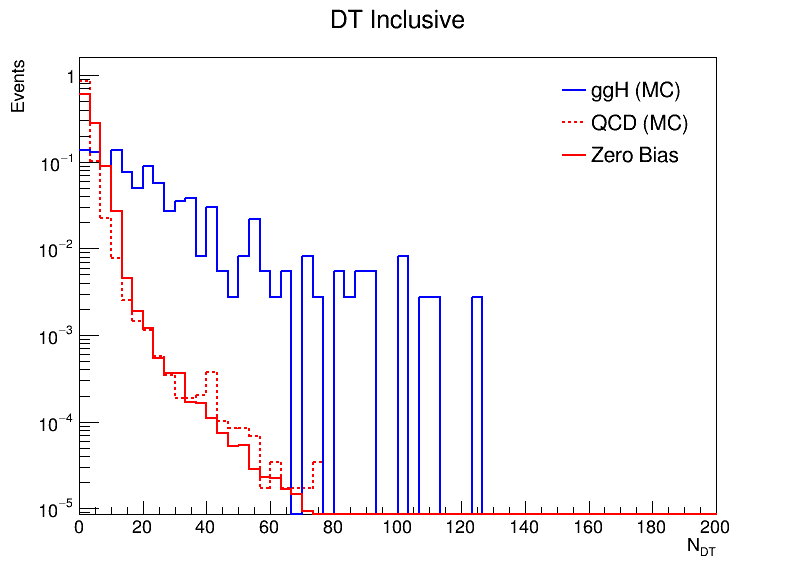

In [72]:
c = rt.TCanvas('c','c', 800, 600)
h = {}
h['nDt_ggH'] = create_TH1D(nDt['ggH'], axis_title=['nDt_ggH', 'Events'], name='nDt_ggH', binning=[150,0,500])
h['nDt_ggH'].SetLineColor(4)

h['nDt_qcd'] = create_TH1D(nDt['qcd'], axis_title=['nDt_qcd', 'Events'], name='nDt_qcd', binning=[150,0,500])
h['nDt_qcd'].SetLineColor(2)
h['nDt_qcd'].SetLineStyle(2)


h['nDt_zeroBias'] = create_TH1D(nDt['zeroBias'], axis_title=['nDt_zeroBias', 'Events'], name='nDt_zeroBias', binning=[150,0,500])
h['nDt_zeroBias'].SetLineColor(2)
h['nDt_zeroBias'].SetLineStyle(1)

c.SetLogy()

h['nDt_ggH'].Scale(1.0/h['nDt_ggH'].Integral())
h['nDt_qcd'].Scale(1.0/h['nDt_qcd'].Integral())
h['nDt_zeroBias'].Scale(1.0/h['nDt_zeroBias'].Integral())


h['nDt_ggH'].SetLineWidth(2)
h['nDt_qcd'].SetLineWidth(2)
h['nDt_zeroBias'].SetLineWidth(2)

h['nDt_ggH'].GetXaxis().SetRangeUser(0,200)
h['nDt_qcd'].GetXaxis().SetRangeUser(0,200)
h['nDt_zeroBias'].GetXaxis().SetRangeUser(0,200)


h['nDt_qcd'].SetStats(0)
h['nDt_qcd'].SetTitle("DT Inclusive")
h['nDt_qcd'].SetXTitle("N_{DT}")


h['nDt_qcd'].Draw('histo')
h['nDt_ggH'].Draw('histo+same')
h['nDt_zeroBias'].Draw('histo+same')

legend = rt.TLegend(0.70,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
#legend-.SetFillStyle(0);
legend.AddEntry( h['nDt_ggH'], "ggH (MC)" , "L");
legend.AddEntry( h['nDt_qcd'], "QCD (MC)" , "L");
legend.AddEntry( h['nDt_zeroBias'], "Zero Bias" , "L");

legend.Draw();

c.Draw()

# c.SaveAs("ncsc_inclusive_mc_zeroBias.pdf")
# c.SaveAs("ncsc_inclusive_mc_zeroBias.C")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Warning in <TROOT::Append>: Replacing existing TH1: nDt_ggH (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nDt_qcd (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nDt_zeroBias (Potential memory leak).


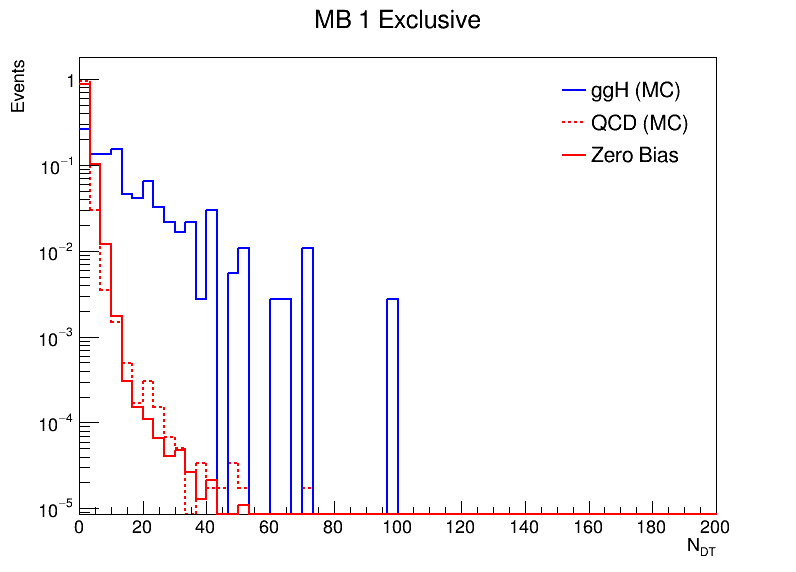

In [88]:
c2 = rt.TCanvas('c2','c2', 800, 600)

h['nDt_ggH'] = create_TH1D(nDt_removal['ggH']['MB_11'], axis_title=['nDt_ggH', 'Events'], name='nDt_ggH', binning=[150,0,500])
h['nDt_ggH'].SetLineColor(4)

h['nDt_qcd'] = create_TH1D(nDt_removal['qcd']['MB_11'], axis_title=['nDt_qcd', 'Events'], name='nDt_qcd', binning=[150,0,500])
h['nDt_qcd'].SetLineColor(2)
h['nDt_qcd'].SetLineStyle(2)


h['nDt_zeroBias'] = create_TH1D(nDt_removal['zeroBias']['MB_11'], axis_title=['nDt_zeroBias', 'Events'], name='nDt_zeroBias', binning=[150,0,500])
h['nDt_zeroBias'].SetLineColor(2)
h['nDt_zeroBias'].SetLineStyle(1)

c2.SetLogy()

h['nDt_ggH'].Scale(1.0/h['nDt_ggH'].Integral())
h['nDt_qcd'].Scale(1.0/h['nDt_qcd'].Integral())
h['nDt_zeroBias'].Scale(1.0/h['nDt_zeroBias'].Integral())


h['nDt_ggH'].SetLineWidth(2)
h['nDt_qcd'].SetLineWidth(2)
h['nDt_zeroBias'].SetLineWidth(2)

# h['nDt_ggH'].GetXaxis().SetRangeUser(0,200)
h['nDt_qcd'].GetXaxis().SetRangeUser(0,200)
# h['nDt_zeroBias'].GetXaxis().SetRangeUser(0,200)


h['nDt_qcd'].SetStats(0)
h['nDt_qcd'].SetTitle("MB 1 Exclusive")
h['nDt_qcd'].SetXTitle("N_{DT}")


h['nDt_qcd'].Draw('histo')
h['nDt_ggH'].Draw('histo+same')
h['nDt_zeroBias'].Draw('histo+same')

legend = rt.TLegend(0.70,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
#legend-.SetFillStyle(0);
legend.AddEntry( h['nDt_ggH'], "ggH (MC)" , "L");
legend.AddEntry( h['nDt_qcd'], "QCD (MC)" , "L");
legend.AddEntry( h['nDt_zeroBias'], "Zero Bias" , "L");

legend.Draw();

c2.Draw()

# c2.SaveAs("ncsc_noME11_mc_zeroBias.pdf")
# c2.SaveAs("ncsc_noME11_mc_zeroBias.C")

In [74]:
print(nRpc['zeroBias'])

[ 2  5  9 ...  3  1 10]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cRpc
Warning in <TROOT::Append>: Replacing existing TH1: nRpc_ggH (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nRpc_qcd (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nRpc_zeroBias (Potential memory leak).


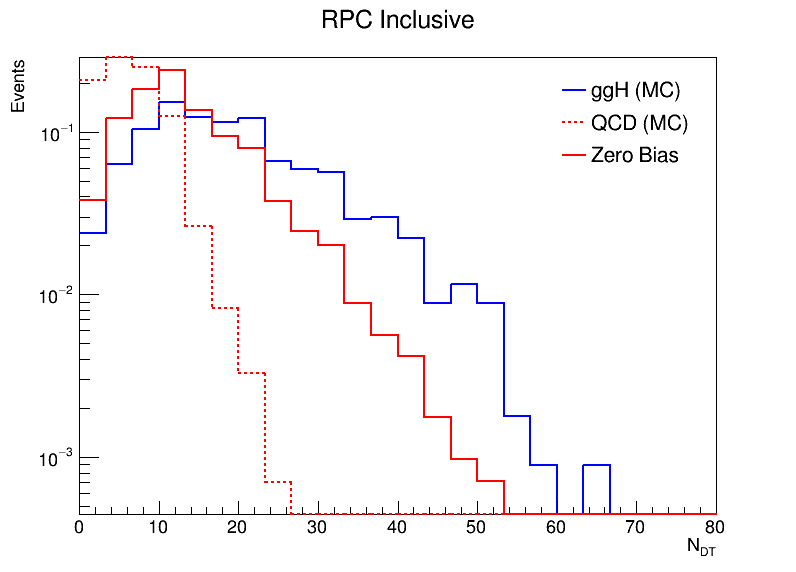

In [86]:
cRpc = rt.TCanvas('cRpc','cRpc', 800, 600)
# h = {}
h['nRpc_ggH'] = create_TH1D(nRpc['ggH'], axis_title=['nRpc_ggH', 'Events'], name='nRpc_ggH', binning=[150,0,500])
h['nRpc_ggH'].SetLineColor(4)

h['nRpc_qcd'] = create_TH1D(nRpc['qcd'], axis_title=['nRpc_qcd', 'Events'], name='nRpc_qcd', binning=[150,0,500])
h['nRpc_qcd'].SetLineColor(2)
h['nRpc_qcd'].SetLineStyle(2)


h['nRpc_zeroBias'] = create_TH1D(nRpc['zeroBias'], axis_title=['nRpc_zeroBias', 'Events'], name='nRpc_zeroBias', binning=[150,0,500])
h['nRpc_zeroBias'].SetLineColor(2)
h['nRpc_zeroBias'].SetLineStyle(1)

cRpc.SetLogy()

h['nRpc_ggH'].Scale(1.0/h['nRpc_ggH'].Integral())
h['nRpc_qcd'].Scale(1.0/h['nRpc_qcd'].Integral())
h['nRpc_zeroBias'].Scale(1.0/h['nRpc_zeroBias'].Integral())


h['nRpc_ggH'].SetLineWidth(2)
h['nRpc_qcd'].SetLineWidth(2)
h['nRpc_zeroBias'].SetLineWidth(2)

h['nRpc_ggH'].GetXaxis().SetRangeUser(0,80)
# h['nRpc_qcd'].GetXaxis().SetRangeUser(0,200)
# h['nRpc_zeroBias'].GetXaxis().SetRangeUser(0,200)


h['nRpc_ggH'].SetStats(0)
h['nRpc_ggH'].SetTitle("RPC Inclusive")
h['nRpc_ggH'].SetXTitle("N_{DT}")


h['nRpc_ggH'].Draw('histo')
h['nRpc_qcd'].Draw('histo+same')
h['nRpc_zeroBias'].Draw('histo+same')

legend = rt.TLegend(0.70,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
#legend-.SetFillStyle(0);
legend.AddEntry( h['nRpc_ggH'], "ggH (MC)" , "L");
legend.AddEntry( h['nRpc_qcd'], "QCD (MC)" , "L");
legend.AddEntry( h['nRpc_zeroBias'], "Zero Bias" , "L");

legend.Draw();

cRpc.Draw()

In [81]:
# ROC Curve for ggH/QCD/ZeroBias Samples: nDt 

eff_ndt = {}
eff_nrpc = {}
rejection_power = {}
ndt_var_x = np.array([])

for data_type in data_trees.keys():
    if data_type != 'm975ct1m':
        eff_ndt[data_type] = {}
        eff_nrpc[data_type] = {}

    #     eff_ndt[data_type]['cluster'] = {}
    #     eff_ndt[data_type]['cluster']['dt_inclusive'] = np.array([])
    #     eff_ndt[data_type]['cluster']['dt_noMB11'] = np.array([])
    #     eff_ndt[data_type]['cluster']['dt_noMB112'] = np.array([])
    #     eff_ndt[data_type]['cluster']['dt_noMB1123'] = np.array([])

        eff_ndt[data_type]['noCluster'] = {}
        eff_ndt[data_type]['noCluster']['dt_inclusive'] = np.array([])
        eff_ndt[data_type]['noCluster']['dt_noMB11'] = np.array([])
        eff_ndt[data_type]['noCluster']['dt_noMB112'] = np.array([])
        
        eff_nrpc[data_type]['noCluster'] = {}
        eff_nrpc[data_type]['noCluster']['rpc_inclusive'] = np.array([])
        

        for hit_thresh in range(0, 200):
            ndt_var_x = np.append(ndt_var_x, hit_thresh)
            # Clustering ROCs
    #         eff_ndt[data_type]['cluster']['dt_inclusive'] = np.append(eff_ndt[data_type]['cluster']['dt_inclusive'], np.count_nonzero(np.array(nDt_cluster[data_type]['dt_inclusive'])>hit_thresh)/len(nDt_cluster[data_type]['dt_inclusive']))
    #         eff_ndt[data_type]['cluster']['dt_noMB11'] = np.append(eff_ndt[data_type]['cluster']['dt_noMB11'], np.count_nonzero(np.array(nDt_cluster[data_type]['dt_noMB11'])>hit_thresh)/len(nDt_cluster[data_type]['dt_noMB11']))
    #         eff_ndt[data_type]['cluster']['dt_noMB112'] = np.append(eff_ndt[data_type]['cluster']['dt_noMB112'], np.count_nonzero(np.array(nDt_cluster[data_type]['dt_noMB112'])>hit_thresh)/len(nDt_cluster[data_type]['dt_noMB112']))
    #         eff_ndt[data_type]['cluster']['dt_noMB1123'] = np.append(eff_ndt[data_type]['cluster']['dt_noMB1123'], np.count_nonzero(np.array(nDt_cluster[data_type]['dt_noMB1123'])>hit_thresh)/len(nDt_cluster[data_type]['dt_noMB1123']))

           # No-Clustering ROCs
            eff_ndt[data_type]['noCluster']['dt_inclusive'] = np.append(eff_ndt[data_type]['noCluster']['dt_inclusive'], np.count_nonzero(np.array(nDt[data_type])>hit_thresh)/len(nDt[data_type]))
            eff_ndt[data_type]['noCluster']['dt_noMB11'] = np.append(eff_ndt[data_type]['noCluster']['dt_noMB11'], np.count_nonzero(np.array(nDt_removal[data_type]['MB_11'])>hit_thresh)/len(nDt_removal[data_type]['MB_11']))
            eff_ndt[data_type]['noCluster']['dt_noMB112'] = np.append(eff_ndt[data_type]['noCluster']['dt_noMB112'], np.count_nonzero(np.array(nDt_removal[data_type]['MB_112'])>hit_thresh)/len(nDt_removal[data_type]['MB_112']))

            eff_nrpc[data_type]['noCluster']['rpc_inclusive'] = np.append(eff_nrpc[data_type]['noCluster']['rpc_inclusive'], np.count_nonzero(np.array(nRpc[data_type])>hit_thresh)/len(nRpc[data_type]))

        # Rejection power calculation
        rejection_power[data_type] = {}
    #     rejection_power[data_type]['cluster'] = {}
        rejection_power[data_type]['noCluster'] = {}

        # Clustering
    #     rejection_power[data_type]['cluster']['dt_inclusive'] = np.reciprocal(np.trim_zeros(eff_ndt[data_type]['cluster']['dt_inclusive']))
    #     rejection_power[data_type]['cluster']['dt_noMB11'] = np.reciprocal(np.trim_zeros(eff_ndt[data_type]['cluster']['dt_noMB11']))
    #     rejection_power[data_type]['cluster']['dt_noMB112'] = np.reciprocal(np.trim_zeros(eff_ndt[data_type]['cluster']['dt_noMB112']))
    #     rejection_power[data_type]['cluster']['dt_noMB1123'] = np.reciprocal(np.trim_zeros(eff_ndt[data_type]['cluster']['dt_noMB1123']))
        # No clustering
        rejection_power[data_type]['noCluster']['dt_inclusive'] = np.reciprocal(np.trim_zeros(eff_ndt[data_type]['noCluster']['dt_inclusive']))
        rejection_power[data_type]['noCluster']['dt_noMB11'] = np.reciprocal(np.trim_zeros(eff_ndt[data_type]['noCluster']['dt_noMB11']))
        rejection_power[data_type]['noCluster']['dt_noMB112'] = np.reciprocal(np.trim_zeros(eff_ndt[data_type]['noCluster']['dt_noMB112']))
        
        rejection_power[data_type]['noCluster']['rpc_inclusive'] = np.reciprocal(np.trim_zeros(eff_nrpc[data_type]['noCluster']['rpc_inclusive']))
    else:
        pass

length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3
Warning in <TLegend::Paint>: Legend to large to be automatically placed. A default position is used


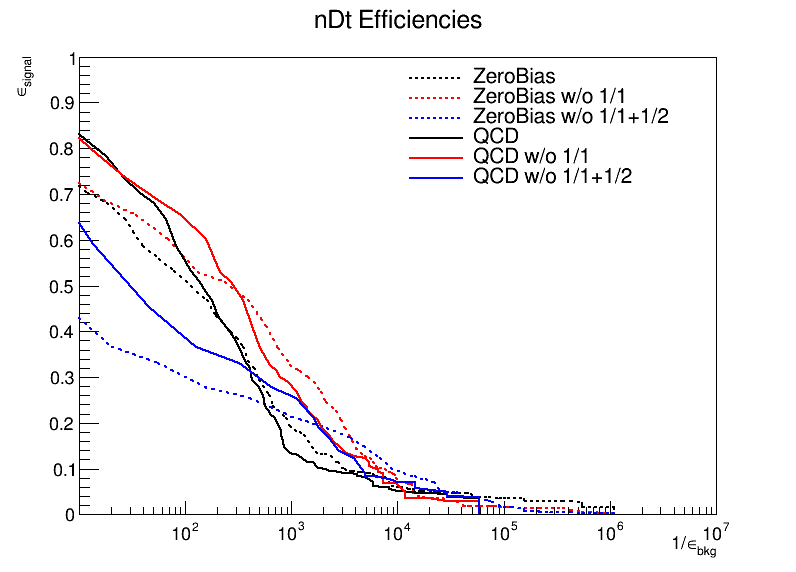

In [82]:
c3 = rt.TCanvas('c3','c3', 800, 600)

h['roc_inclusive_zeroBias'] = create_TGraph(rejection_power['zeroBias']['noCluster']['dt_inclusive'], eff_ndt['ggH']['noCluster']['dt_inclusive'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_no_mb11_zeroBias'] = create_TGraph(rejection_power['zeroBias']['noCluster']['dt_noMB11'], eff_ndt['ggH']['noCluster']['dt_noMB11'], axis_title=['#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_no_mb112_zeroBias'] = create_TGraph(rejection_power['zeroBias']['noCluster']['dt_noMB112'], eff_ndt['ggH']['noCluster']['dt_noMB112'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])

h['roc_inclusive_qcd'] = create_TGraph(rejection_power['qcd']['noCluster']['dt_inclusive'], eff_ndt['ggH']['noCluster']['dt_inclusive'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_no_mb11_qcd'] = create_TGraph(rejection_power['qcd']['noCluster']['dt_noMB11'], eff_ndt['ggH']['noCluster']['dt_noMB11'], axis_title=['#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_no_mb112_qcd'] = create_TGraph(rejection_power['qcd']['noCluster']['dt_noMB112'], eff_ndt['ggH']['noCluster']['dt_noMB112'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])

c3.SetLogx()
# c3.SetLogy()

h['roc_inclusive_zeroBias'].SetTitle('nDt Efficiencies')

h['roc_inclusive_zeroBias'].SetLineWidth(2)
h['roc_no_mb11_zeroBias'].SetLineWidth(2)
h['roc_no_mb112_zeroBias'].SetLineWidth(2)

h['roc_inclusive_qcd'].SetLineWidth(2)
h['roc_no_mb11_qcd'].SetLineWidth(2)
h['roc_no_mb112_qcd'].SetLineWidth(2)

h['roc_inclusive_zeroBias'].SetLineColor(1)
h['roc_inclusive_zeroBias'].SetLineStyle(2)


h['roc_no_mb11_zeroBias'].SetLineColor(2)
h['roc_no_mb11_zeroBias'].SetLineStyle(2)

h['roc_no_mb112_zeroBias'].SetLineColor(4)
h['roc_no_mb112_zeroBias'].SetLineStyle(2)

### QCD

h['roc_inclusive_qcd'].SetLineColor(1)
h['roc_inclusive_qcd'].SetLineStyle(1)

h['roc_no_mb11_qcd'].SetLineColor(2)
h['roc_no_mb11_qcd'].SetLineStyle(1)

h['roc_no_mb112_qcd'].SetLineColor(4)
h['roc_no_mb112_qcd'].SetLineStyle(1)

####

h['roc_inclusive_zeroBias'].GetXaxis().SetLimits(10, 10000000)
h['roc_inclusive_zeroBias'].GetYaxis().SetRangeUser(0,1)



h['roc_inclusive_zeroBias'].Draw()
h['roc_no_mb11_zeroBias'].Draw('same')
h['roc_no_mb112_zeroBias'].Draw('same')

h['roc_inclusive_qcd'].Draw('same')
h['roc_no_mb11_qcd'].Draw('same')
h['roc_no_mb112_qcd'].Draw('same')


legend = rt.TLegend(0.70,0.70,0.7,0.7);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);

legend.AddEntry( h['roc_inclusive_zeroBias'], "ZeroBias", 'l');
legend.AddEntry( h['roc_no_mb11_zeroBias'], "ZeroBias w/o 1/1", 'l');
legend.AddEntry( h['roc_no_mb112_zeroBias'], "ZeroBias w/o 1/1+1/2", 'l');
legend.AddEntry( h['roc_inclusive_qcd'], "QCD", 'l');
legend.AddEntry( h['roc_no_mb11_qcd'], "QCD w/o 1/1", 'l');
legend.AddEntry( h['roc_no_mb112_qcd'], "QCD w/o 1/1+1/2", 'l');


legend.Draw();

c3.Draw()

# c3.SaveAs("noCluster_roc.pdf")
# c3.SaveAs("noCluster_roc.C")

length of x and y are not equal!
length of x and y are not equal!


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c4
Warning in <TLegend::Paint>: Legend to large to be automatically placed. A default position is used


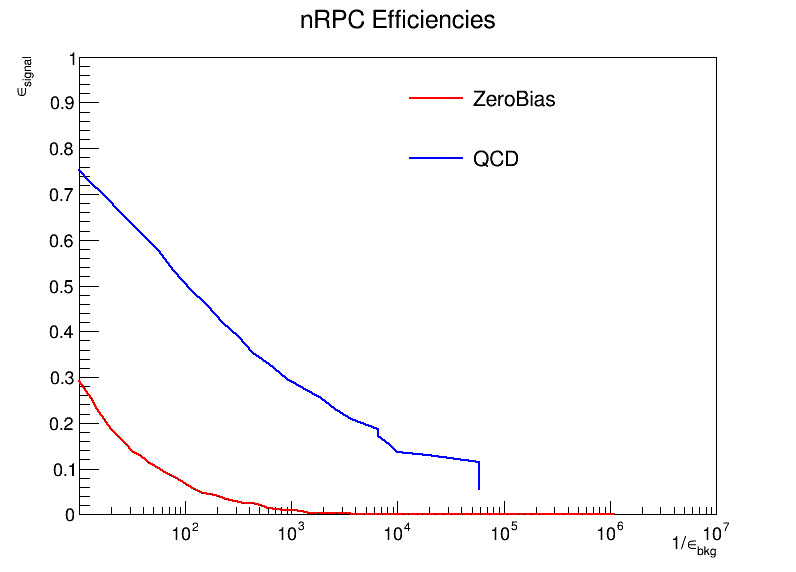

In [84]:
c4 = rt.TCanvas('c4','c4', 800, 600)

h['roc_inclusive_zeroBias_rpc'] = create_TGraph(rejection_power['zeroBias']['noCluster']['rpc_inclusive'], eff_nrpc['ggH']['noCluster']['rpc_inclusive'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])

h['roc_inclusive_qcd_rpc'] = create_TGraph(rejection_power['qcd']['noCluster']['rpc_inclusive'], eff_nrpc['ggH']['noCluster']['rpc_inclusive'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])

c4.SetLogx()
# c3.SetLogy()

h['roc_inclusive_zeroBias_rpc'].SetTitle('nRPC Efficiencies')

h['roc_inclusive_zeroBias_rpc'].SetLineWidth(2)
h['roc_inclusive_qcd_rpc'].SetLineWidth(2)

h['roc_inclusive_zeroBias_rpc'].SetLineColor(2)
h['roc_inclusive_qcd_rpc'].SetLineColor(4)

h['roc_inclusive_zeroBias_rpc'].GetXaxis().SetLimits(10, 10000000)
h['roc_inclusive_zeroBias_rpc'].GetYaxis().SetRangeUser(0,1)



h['roc_inclusive_zeroBias_rpc'].Draw()
h['roc_inclusive_qcd_rpc'].Draw('same')


legend = rt.TLegend(0.70,0.70,0.7,0.7);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);

legend.AddEntry( h['roc_inclusive_zeroBias_rpc'], "ZeroBias", 'l');
legend.AddEntry( h['roc_inclusive_qcd_rpc'], "QCD", 'l');

legend.Draw();

c4.Draw()